## About the Garbage Dataset
This dataset comprises of random images of garbage which are classified by folders. The names of each of these folders are going to be our labels of the images. We use the library “ImageFolder” to load these images into our workspace. Our aim is to make our model identify the images of, cardboard, glass, paper, metal, plastic, trash.



## Importing Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

import matplotlib.pyplot as plt


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

## Loading the Dataset

In [ ]:
data_path = '/content/drive/MyDrive/Datasets/Garbage classification'

In [ ]:
img_size = 120

Transforming the images before importing is critical and we do the following steps:

1.We resize the images into our desired shape i.e, 120*120

2.RandomHorizontalFlip is a part of Data Augmentation. This creates new set of images by flipping which ultimately turns our model smarter.

3.ToTensor(): transforms our images into tensor form

4.We will have to normalize our images by giving the said mean and standard deviation values.

In [ ]:
img_transform = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485,0.456,0.406], 
                  std=[0.229,0.224,0.225])
])

Our data is labelled by the folders the images are in. So, we use ImageFolder Library to load the data into our workspace and then split it into training, testing and validation datasets using the random_split.

In [ ]:
img_data = ImageFolder(root = data_path, transform=img_transform)

In [ ]:
img_data.class_to_idx

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [ ]:
len(img_data)

2527

In [ ]:
train_data, val_data, test_data = random_split(img_data, [1800,627,100])

In [ ]:
len(train_data)

1800

To not overload our model, we use DataLoader to divide our dataset into batches. This helps us with the memory management.

In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [ ]:
for images, labels in train_loader:
  print(images.shape, labels.shape)
  break

torch.Size([32, 3, 120, 120]) torch.Size([32])


## Visualizing the Dataset

In [ ]:
def show_img_batch(data):
  for images, labels  in data:
    plt.figure(figsize = (20,15))
    plt.imshow(make_grid(images,nrow = 16).permute(1,2,0))
    plt.show()
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


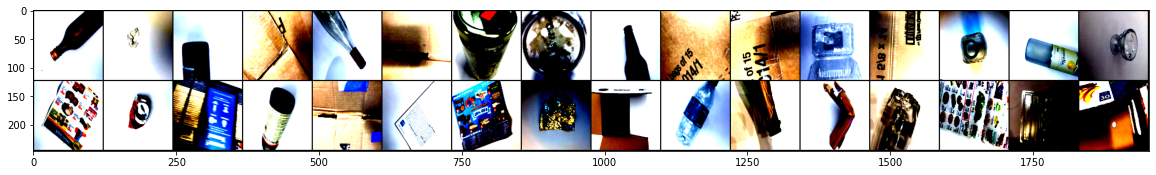

In [ ]:
show_img_batch(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


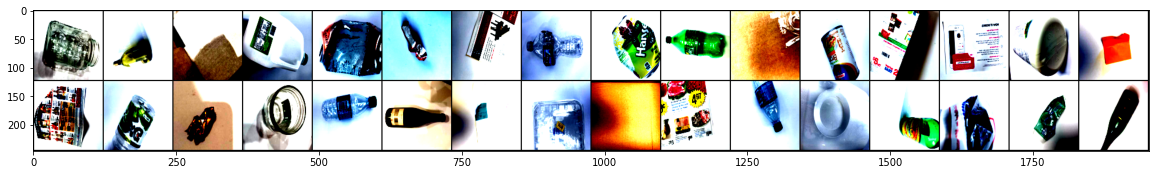

In [ ]:
show_img_batch(val_loader)

# Creating our CNN Model

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
    self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
    self.conv4 = nn.Conv2d(in_channels=256, out_channels=352, kernel_size=3)
    self.conv5 = nn.Conv2d(in_channels=352, out_channels=512, kernel_size=3)
    self.pool = nn.MaxPool2d(2)
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(512, 256)
    self.fc2 = nn.Linear(256,128)
    self.fc3 = nn.Linear(128,6)
    self.dropout = nn.Dropout(0.1)

  def forward(self, img):
    out = self.conv1(img)
    out = self.relu(out)
    out = self.pool(out)
    out = self.conv2(out)
    out = self.relu(out)
    out = self.pool(out)
    out = self.conv3(out)
    out = self.relu(out)
    out = self.pool(out)
    out = self.conv4(out)
    out = self.relu(out)
    out = self.pool(out)
    out = self.conv5(out)
    out = self.relu(out)
    out = self.pool(out)

    out = out.view(-1, 512)

    out = self.fc1(out)
    out = self.relu(out)
    out = self.dropout(out)
    out = self.fc2(out)
    out = self.relu(out)
    out = self.dropout(out)
    out = self.fc3(out)

    return out


In [ ]:
model = CNN().to(device)
print(model.parameters)

<bound method Module.parameters of CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(256, 352, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(352, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=6, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)>


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def CNN_train(loss_fn, optimizer):
    
    epochs = 20
    
    training_loss = []
    training_acc = []
    testing_loss = []
    testing_acc = []
    
    for epoch in range(epochs):
        
        train_acc = 0.0
        train_loss = 0.0
        
        model.train()
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = loss_fn(output, labels)
            
            loss.backward()
            optimizer.step()
            
            predictions = torch.argmax(output,1)
            
            train_acc += (predictions==labels).sum().item()
            train_loss += loss.item()
            
        training_acc.append(train_acc/len(train_data))
        training_loss.append(train_loss/len(train_loader))
        
        model.eval()
        
        test_acc = 0.0
        test_loss = 0.0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                output = model(images)
                loss = loss_fn(output, labels)
                
                predictions = torch.argmax(output,1)
                
                test_acc += (predictions==labels).sum().item()
                test_loss += loss.item()
                
            testing_acc.append(test_acc/len(val_data))
            testing_loss.append(test_loss/len(val_loader))
            
        print("Epochs:{},Training Accuracy:{:.2f},Training Loss:{:.2f},Validation Accuracy:{:.2f},Validation Loss:{:.2f}.".
             format(epoch+1, train_acc/len(train_data), train_loss/len(train_loader), test_acc/len(val_data),
                   test_loss/len(val_loader)))
        
    plt.title("Accuracy Vs Epohcs")
    plt.plot(range(epochs), training_acc, label="Training Accuracy")
    plt.plot(range(epochs), testing_acc, label="Validation Accuracy")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()
    
    plt.title("Loss Vs Epochs")
    plt.plot(range(epochs), testing_loss, label="Validation Loss")
    plt.plot(range(epochs), training_loss, label = "Training Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()
    

Epochs:1,Training Accuracy:0.24,Training Loss:1.71,Validation Accuracy:0.30,Validation Loss:1.67.
Epochs:2,Training Accuracy:0.33,Training Loss:1.57,Validation Accuracy:0.37,Validation Loss:1.49.
Epochs:3,Training Accuracy:0.40,Training Loss:1.46,Validation Accuracy:0.44,Validation Loss:1.38.
Epochs:4,Training Accuracy:0.39,Training Loss:1.42,Validation Accuracy:0.40,Validation Loss:1.40.
Epochs:5,Training Accuracy:0.44,Training Loss:1.38,Validation Accuracy:0.46,Validation Loss:1.30.
Epochs:6,Training Accuracy:0.46,Training Loss:1.30,Validation Accuracy:0.46,Validation Loss:1.28.
Epochs:7,Training Accuracy:0.47,Training Loss:1.28,Validation Accuracy:0.48,Validation Loss:1.30.
Epochs:8,Training Accuracy:0.49,Training Loss:1.27,Validation Accuracy:0.46,Validation Loss:1.31.
Epochs:9,Training Accuracy:0.51,Training Loss:1.21,Validation Accuracy:0.56,Validation Loss:1.23.
Epochs:10,Training Accuracy:0.56,Training Loss:1.15,Validation Accuracy:0.54,Validation Loss:1.21.
Epochs:11,Training 

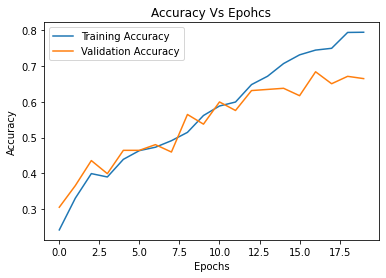

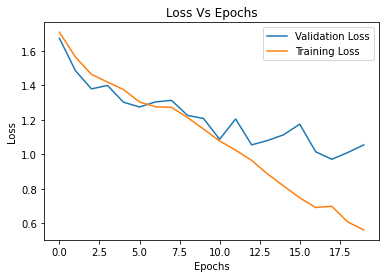

In [ ]:
input: CNN_train(loss_fn, optimizer) 

In [ ]:
def predict_img(img,model):
    img = img.to(device)
    x = img.unsqueeze(0)
    y = model(x)
    
    prediction = torch.argmax(y, dim=1)
    return img_data.classes[prediction]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label :  glass , Predicted Label :  glass


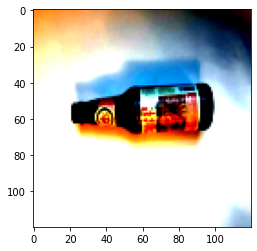

In [ ]:
img, label = test_data[10]
plt.imshow(img.permute(1,2,0))
print("Actual Label : ", img_data.classes[label],', ' "Predicted Label : ", predict_img(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label:  paper , Predicted Label:  paper


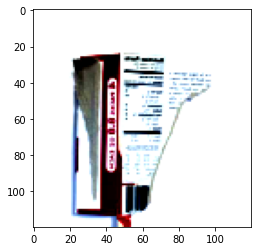

In [ ]:
img, label = test_data[64]
plt.imshow(img.permute(1,2,0))
print("Actual Label: ", img_data.classes[label],', '  "Predicted Label: ", predict_img(img, model))